# Remote sensing and modelling to assess crop-specific response to climate stressors
# CropClim Workshop, TUK, July 18, 2023
# Sentinel 2 based phenometrics for mono and mixed crops
Gohar Ghazaryan


The aim of this excersize is to analyze phenometrics, specifically focusing on  start, end of the season and time of maximum vegetation using NDVI (Normalized Difference Vegetation Index) data. 

## Dataset
The dataset used for this excersize consists of Sentinel-2 satellite images for 2019.  The images were clipped to the small area of interest and two indices (NDVI and NDMI were calculated). 
The reference data is extracted from PlantVillage (2019) "PlantVillage Kenya Ground Reference Crop Type Dataset", Version 1.0, Radiant MLHub. [Date Accessed] https://doi.org/10.34911/RDNT.U41J87

## Methodology

The script performs the following steps:

1. **TS Extraction**  time series for selected field
2. **Smoothing**  Smoothing the NDVI and NDMI (Normalized Difference Moisture Index) data using the Savitzky-Golay filter.
3. **Peak of the Season** Identifying the date of maximum NDVI and its corresponding day of year (DOY).
3. Calculating the first-order differences of the smoothed NDVI.
4.  **Start and End of the Season** Finding the indices where the differences are positive (indicating an increase in NDVI) and negative (indicating a decrease in NDVI).

If you dont have the libraries installed use the following in the anaconda prompt:

1. conda install -c anaconda pip
2. conda create --name CropClimW
3. conda activate CropClimW
4. pip install scikit-learn rasterio rioxarray numpy xarray geopandas pandas matplotlib scipy



In [38]:
# Load the necessary libraries
import os
import glob
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


# Directory of images
dir_path = 'D:/05_Data/Kenya_cropClimTraining/raster/rasterV3'
image_paths = sorted(glob.glob(os.path.join(dir_path, 'Sentinel2_*.tif')))

# Read the shapefile
shp = gpd.read_file('D:/05_Data/Kenya_cropClimTraining/Final shapefiles/Training_polyons.shp')

# Select polygon for the desired crop type
polygon = shp.loc[shp['Crop_type'] == 'Maize', 'geometry'].values[1]
print(polygon)

POLYGON ((34.23271403698979 0.5666112755329961, 34.23301894830135 0.5664611896542484, 34.23245810107024 0.5656428266522351, 34.232415445083646 0.5657660550579436, 34.23243440329991 0.5659193006394018, 34.232372789097056 0.5660093521666504, 34.23237436894841 0.5660978238425437, 34.232559211556975 0.5664074747081703, 34.23271403698979 0.5666112755329961))


In [40]:
# Initialize empty lists to store max NDVI and NDMI
max_ndvi = []
max_ndmi = []

# Loop over each image
for image_path in image_paths:
    # Open the image
    with rasterio.open(image_path) as src:
        # Crop image to the polygon and mask outside the polygon
        out_image, out_transform = mask(src, [mapping(polygon)], crop=True)

        # NDVI is first band
        ndvi_band = out_image[0]
        ndvi_band = ndvi_band[ndvi_band != src.nodata]  # Exclude nodata values

        # NDMI is second band
        ndmi_band = out_image[1]
        ndmi_band = ndmi_band[ndmi_band != src.nodata]  # Exclude nodata values

        # Calculate max NDVI and NDMI and add to lists
        max_ndvi.append(ndvi_band.max() if ndvi_band.size != 0 else np.nan)
        max_ndmi.append(ndmi_band.max() if ndmi_band.size != 0 else np.nan)

# Extract dates from image filenames
dates = [pd.to_datetime('2019-' + str(int(os.path.basename(image_path).split('_')[2].split('.')[0])+1)) for image_path in image_paths]

# Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'max_ndvi': max_ndvi,
    'max_ndmi': max_ndmi
})

print(df.head)

<bound method NDFrame.head of          date  max_ndvi  max_ndmi
0  2019-01-01  0.681722  0.209489
1  2019-02-01  0.563363  0.092982
2  2019-11-01  0.768216  0.344591
3  2019-12-01       NaN       NaN
4  2019-03-01  0.529965  0.070724
5  2019-04-01  0.513593  0.003536
6  2019-05-01  0.695517  0.405362
7  2019-06-01  0.685777  0.276977
8  2019-07-01  0.735679  0.371783
9  2019-08-01  0.724994  0.286768
10 2019-09-01  0.679812  0.233580
11 2019-10-01  0.700157  0.277619>


In [46]:
from scipy import stats
print(df['max_ndvi'].isnull().any())

df['max_ndvi'] = df['max_ndvi'].replace([np.inf, -np.inf], np.nan)
df['max_ndvi'] = df['max_ndvi'].dropna()
df['max_ndvi'] = df['max_ndvi'].interpolate()
df['max_ndmi'] = df['max_ndmi'].interpolate()
print(df['max_ndvi'].isnull().any())


False
False


Date of max NDVI: 2019-07-01 00:00:00
Day of year of max NDVI: 182
Start of the season: 2019-05-01 00:00:00
End of the season: 2019-08-01 00:00:00


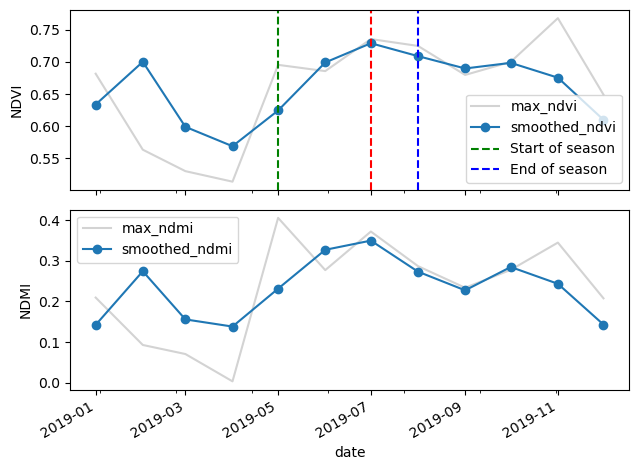

In [51]:


# Set window and polynomial order parameters for the Savitzky-Golay filter
window_length = 7
polyorder = 3

# Interpolate the data to fill missing values
df['max_ndvi'].interpolate(method='time', inplace=True)
df['max_ndmi'].interpolate(method='time', inplace=True)

# Apply the Savitzky-Golay filter to smooth the NDVI and NDMI data
df['smoothed_ndvi'] = savgol_filter(df['max_ndvi'], window_length, polyorder)
df['smoothed_ndmi'] = savgol_filter(df['max_ndmi'], window_length, polyorder)

# Plot the smoothed data
fig, ax = plt.subplots(2, 1, sharex=True)
df.plot(y='max_ndvi', ax=ax[0], color='lightgray')
df.plot(y='smoothed_ndvi', marker='o', ax=ax[0])
ax[0].set_ylabel('NDVI')

df.plot(y='max_ndmi', ax=ax[1], color='lightgray')
df.plot(y='smoothed_ndmi', marker='o', ax=ax[1])
ax[1].set_ylabel('NDMI')

# Identify and plot the phenometrics
max_ndvi_date = df['smoothed_ndvi'].idxmax()  # date of max NDVI
max_ndvi_doy = max_ndvi_date.dayofyear  # day of year of max NDVI

# Add vertical line to the NDVI plot
ax[0].axvline(max_ndvi_date, color='r', linestyle='--')

# Calculate the first-order differences of the smoothed NDVI
df['diff_ndvi'] = df['smoothed_ndvi'].diff()

# Find the indices where the differences are positive (indicating an increase in NDVI)
positive_diff_indices = np.where(df['diff_ndvi'] > 0)[0]

# Identify the position of max_ndvi_date in the DataFrame
max_ndvi_index = df.index.get_loc(max_ndvi_date)

# Find the indices where the differences are negative (indicating a decrease in NDVI) after the max index
negative_diff_indices = np.where(df['diff_ndvi'].values[max_ndvi_index:] < 0)[0]

# Adjust the indices by adding the max index to get the correct indices in the original dataframe
negative_diff_indices += max_ndvi_index

# Calculate the slopes for the positive and negative differences
positive_slopes = np.diff(df['smoothed_ndvi'].iloc[positive_diff_indices])
negative_slopes = np.diff(df['smoothed_ndvi'].iloc[negative_diff_indices])

# Find the index of the maximum positive slope (start of the season)
start_index = positive_diff_indices[np.argmax(positive_slopes)]

# Find the index of the maximum negative slope (end of the season)
end_index = negative_diff_indices[np.argmax(negative_slopes)]

# Get the corresponding dates for start and end indices
start_date = df.index[start_index]
end_date = df.index[end_index]

# Add vertical lines to the NDVI plot
ax[0].axvline(start_date, color='g', linestyle='--', label='Start of season')
ax[0].axvline(end_date, color='b', linestyle='--', label='End of season')

# Add legend
ax[0].legend()

# Show plots
plt.tight_layout()
plt.show()


In [52]:
print(f'Start of the season: {start_date}')
print(f'End of the season: {end_date}')
print(f'Date of max NDVI: {max_ndvi_date}')
print(f'Day of year of max NDVI: {max_ndvi_doy}')

Start of the season: 2019-05-01 00:00:00
End of the season: 2019-08-01 00:00:00
Date of max NDVI: 2019-07-01 00:00:00
Day of year of max NDVI: 182
